# Flame AI


# Libraries

In [2]:
import cv2
import numpy as np
import cv2 as cv
import colorsys
import sys
import os
import imageio
from PIL import Image
from lxml import etree
import pandas as pd
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.measure import label, regionprops
#from utils.util_scripts import is_intersection
import logging

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure


from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from scipy.spatial import distance

# Contour Functions


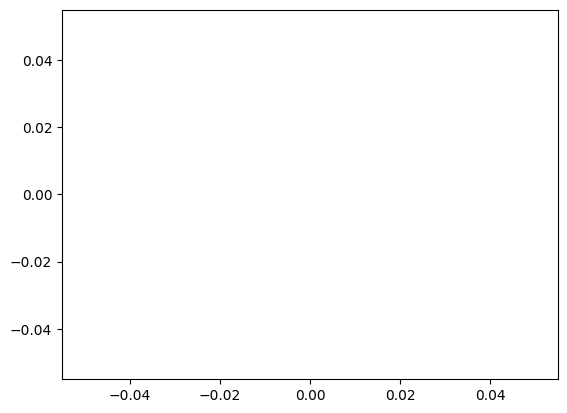

In [16]:
###########BEST###################

# Initialize plot
plt.ion()
fig, ax = plt.subplots()
areas = []
line, = ax.plot([], [])

def merge_contours(contours, max_distance=70):
    merged_contours = []
    used = [False] * len(contours)

    def get_centroid(contour):
        M = cv2.moments(contour)
        if M['m00'] == 0:
            return None
        return (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))

    for i, c1 in enumerate(contours):
        if used[i]:
            continue
        merged = [c1]
        centroid1 = get_centroid(c1)
        if centroid1 is None:
            continue
        for j, c2 in enumerate(contours):
            if i != j and not used[j]:
                centroid2 = get_centroid(c2)
                if centroid2 is None:
                    continue
                dist = np.linalg.norm(np.array(centroid1) - np.array(centroid2))
                if dist < max_distance:  # Merge if within max_distance
                    merged.append(c2)
                    used[j] = True
        merged = np.vstack(merged)
        merged_contours.append(merged)
        used[i] = True

    return merged_contours

def extract_features(frame):
    img = frame[:, :, 1]
    img[0:40, :] = 0
    img[frame.shape[0] - 21:frame.shape[0] - 1, :] = 0
    img[:, 0:40] = 0
    img[:, frame.shape[1] - 21:frame.shape[1] - 1] = 0

    _, B2 = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)
    B2 = cv2.morphologyEx(B2, cv2.MORPH_CLOSE, np.ones((10, 10)))

    contours, _ = cv2.findContours(B2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Merge contours that are close to each other
    contours = merge_contours(contours)

    features = {}
    for contour_id, c in enumerate(contours, start=1):
        if cv2.contourArea(c) > 100:
            rect = cv2.minAreaRect(c)
            center, size, angle = rect
            width, height = size
            area = width * height

            features[f'centerX_{contour_id}'] = center[0]
            features[f'centerY_{contour_id}'] = center[1]
            features[f'width_{contour_id}'] = width
            features[f'height_{contour_id}'] = height
            features[f'angle_{contour_id}'] = angle
            features[f'area_{contour_id}'] = area

    return features, B2, contours

def update_plot(frame_area):
    areas.append(frame_area)
    line.set_xdata(range(len(areas)))
    line.set_ydata(areas)
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw()
    fig.canvas.flush_events()

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    all_features = []
    max_contours = 0
    contour_ids = {}

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_features, B2, contours = extract_features(frame)
        current_ids = {}

        for contour_id, c in enumerate(contours, start=1):
            rect = cv2.minAreaRect(c)
            center, size, angle = rect
            width, height = size
            area = width * height
            centroid = (int(center[0]), int(center[1]))

            # Match contours with existing IDs
            matched = False
            for existing_id, existing_centroid in contour_ids.items():
                if np.linalg.norm(np.array(existing_centroid) - np.array(centroid)) < 50:  # Distance threshold
                    current_ids[existing_id] = centroid
                    frame_features[f'centerX_{existing_id}'] = center[0]
                    frame_features[f'centerY_{existing_id}'] = center[1]
                    frame_features[f'width_{existing_id}'] = width
                    frame_features[f'height_{existing_id}'] = height
                    frame_features[f'angle_{existing_id}'] = angle
                    frame_features[f'area_{existing_id}'] = area
                    matched = True
                    break

            if not matched:
                new_id = max(contour_ids.keys(), default=0) + 1
                current_ids[new_id] = centroid
                frame_features[f'centerX_{new_id}'] = center[0]
                frame_features[f'centerY_{new_id}'] = center[1]
                frame_features[f'width_{new_id}'] = width
                frame_features[f'height_{new_id}'] = height
                frame_features[f'angle_{new_id}'] = angle
                frame_features[f'area_{new_id}'] = area

        contour_ids = current_ids
        max_contours = max(max_contours, len(contours))
        all_features.append(frame_features)

        # Draw the contours
        for contour_id in contour_ids.keys():
            center_x = frame_features.get(f'centerX_{contour_id}')
            center_y = frame_features.get(f'centerY_{contour_id}')
            width = frame_features.get(f'width_{contour_id}')
            height = frame_features.get(f'height_{contour_id}')
            angle = frame_features.get(f'angle_{contour_id}')

            if center_x is not None and center_y is not None and width is not None and height is not None and angle is not None:
                box = cv2.boxPoints(((center_x, center_y), (width, height), angle))
                box = np.intp(box)
                frame = cv2.drawContours(frame, [box], 0, (255, 0, 0), 2)

        # Show the frame with bounding boxes
        cv2.imshow("preview", frame)
        if len(frame_features) > 0:
            total_area = sum((frame_features.get(f'width_{i+1}', 0) or 0) * (frame_features.get(f'height_{i+1}', 0) or 0)for i in range(max_contours))
            update_plot(total_area)

        k = cv2.waitKey(30) & 0xFF
        if k == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

    # Ensure all possible contour columns are present in every frame
    for frame in all_features:
        for contour_id in range(1, max_contours + 1):
            for feature in ['centerX', 'centerY', 'width', 'height', 'angle', 'area']:
                frame.setdefault(f'{feature}_{contour_id}', None)

    return all_features


# Main code


In [17]:
# Process the video and get the feature vectors
movie_path = r"C:\Users\thaim\OneDrive\Desktop\Tal_Projects\Gas_detector\General_Codes\Gas_Detector_5_24\Flame_train_AI\Flame_AI_test_video_2 - edit.mp4"
features = process_video(movie_path)

# Convert the flattened features to a DataFrame
df = pd.DataFrame(features)

# Save the DataFrame to a CSV file for later use
df.to_csv("fire_detection_features_corrected.csv", index=False)


# CSV Process

In [8]:
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def process_features(csv_path, output_dir):
    df = pd.read_csv(csv_path)
    
    # Correct object ID extraction based on actual data
    object_ids = set(int(col.split('_')[-1]) for col in df.columns if '_' in col)
    
    ensure_dir(output_dir)
    
    for object_id in object_ids:
        object_dir = os.path.join(output_dir, f"Object_{object_id}")
        ensure_dir(object_dir)
        
        # Include all needed parameters
        parameters = ['centerX', 'centerY', 'area', 'height', 'width', 'angle']
        data_collected = False  # Flag to check if any data is collected

        for param in parameters:
            param_name = f"{param}_{object_id}"
            if param_name in df.columns:
                param_data = df[param_name].dropna().reset_index(drop=True)

                # Create directory for each parameter
                param_dir = os.path.join(object_dir, param)
                ensure_dir(param_dir)

                # Aggregate data with a sliding window of 20 frames
                for start in range(0, len(param_data) - 19):  # ensure we have exactly 20 data points
                    frame_data = param_data[start:start+20]
                    if len(frame_data) == 20:  # Check if we indeed have 20 data points
                        # Create DataFrame, transpose and save to CSV without index and header
                        temp_df = pd.DataFrame([frame_data]).transpose()  # Create and transpose DataFrame
                        vector_file_path = os.path.join(param_dir, f"{param}_{start}.csv")
                        temp_df.to_csv(vector_file_path, header=False, index=False)
                        print(f"Data for {param} of Object {object_id}, window starting at {start}, written to {vector_file_path}")
                        data_collected = True
                
        if not data_collected:
            # Create an empty CSV file if no data was collected for this object
            empty_file_path = os.path.join(object_dir, "not_enough_information_for_this_object.csv")
            pd.DataFrame().to_csv(empty_file_path)
            print(f"No sufficient data for Object {object_id}. Empty file created: {empty_file_path}")

# Example usage
CSV_Path = r"C:\Users\thaim\OneDrive\Desktop\Tal_Projects\Gas_detector\General_Codes\Gas_Detector_5_24\fire_detection_features_corrected.csv"
Output_Dir = r"C:\Users\thaim\OneDrive\Desktop\Tal_Projects\Gas_detector\General_Codes\Gas_detector"
process_features(CSV_Path, Output_Dir)


Data for centerX of Object 1, window starting at 0, written to C:\Users\thaim\OneDrive\Desktop\Tal_Projects\Gas_detector\General_Codes\Gas_detector\Object_1\centerX\centerX_0.csv
Data for centerX of Object 1, window starting at 1, written to C:\Users\thaim\OneDrive\Desktop\Tal_Projects\Gas_detector\General_Codes\Gas_detector\Object_1\centerX\centerX_1.csv
Data for centerX of Object 1, window starting at 2, written to C:\Users\thaim\OneDrive\Desktop\Tal_Projects\Gas_detector\General_Codes\Gas_detector\Object_1\centerX\centerX_2.csv
Data for centerX of Object 1, window starting at 3, written to C:\Users\thaim\OneDrive\Desktop\Tal_Projects\Gas_detector\General_Codes\Gas_detector\Object_1\centerX\centerX_3.csv
Data for centerX of Object 1, window starting at 4, written to C:\Users\thaim\OneDrive\Desktop\Tal_Projects\Gas_detector\General_Codes\Gas_detector\Object_1\centerX\centerX_4.csv
Data for centerX of Object 1, window starting at 5, written to C:\Users\thaim\OneDrive\Desktop\Tal_Projec

# MODEL

In [ ]:

# Neural Network Model
def AI_model_Temporal_1():
    model = Sequential([
        Dense(20, activation="relu", input_shape=(FL_SIZE,)),
        Dropout(0.1),
        Dense(10, activation="relu"),
        Dense(5, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    sgd = keras.optimizers.SGD(learning_rate=0.003, momentum=0.9)
    model.compile(loss="binary_crossentropy", optimizer=sgd, metrics=["accuracy"])
    return model

model = AI_model_Temporal_1()
model.summary()

reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', patience=10, mode='max')
callbacks = [earlyStopping, reduce_lr_acc]

# Assuming X_train2 and Y_train are defined and preprocessed
# history = model.fit(X_train2, Y_train, batch_size=10, epochs=25, validation_split=0.2, shuffle=True)


NameError: name 'FL_SIZE' is not defined

## Load


In [ ]:
flame1=(np.load('flame_1.npy'))
nflame1=(np.load('not_flame_1.npy'))

flame2=(np.load('flame_2.npy'))
nflame2=(np.load('not_flame_2.npy'))

flame3=(np.load('flame_3.npy'))

flame_set=np.concatenate((flame1,flame2))
flame_set=np.concatenate((flame_set,flame3))


Not_flame_set=np.concatenate((nflame1,nflame2))
Not_flame_set=np.concatenate((Not_flame_set,not_flame_array))




In [ ]:
flame_set.shape
flame_label=np.ones(flame_set.shape[0])
Not_flame_label=np.zeros(Not_flame_set.shape[0])

In [ ]:
X_train=np.concatenate((flame_set,Not_flame_set))
Y_train=np.concatenate((flame_label,Not_flame_label))

In [ ]:

for i in range (X_train.shape[0]):
    X_train2[i,:]=X_train[i,:]/np.max(X_train[i,:])

## AI

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
#  רשת א

def AI_model_Temporal_1():   # U
    #Create Model
    model = keras.models.Sequential([keras.Input(shape=(FL_SIZE,)),
                                 keras.layers.Dense(20, activation="relu"),
                                 keras.layers.Dropout(.1),
                                 keras.layers.Dense(10, activation="relu"),
                                 keras.layers.Dense(5, activation="relu"),
                                 keras.layers.Dense(1, activation="sigmoid")
    ])
    

    sgd=keras.optimizers.SGD(learning_rate=0.003, momentum=0.9, nesterov=False, name="SGD")
    adam=keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99,epsilon=1e-07,amsgrad=False,name="Adam",)
    Binary_crossentropy=keras.losses.BinaryCrossentropy( from_logits=False, label_smoothing=0.5,axis=-1,reduction="auto",name="Binary_crossentropy",)
    
    model.compile(loss="binary_crossentropy", optimizer=sgd,metrics=["accuracy"])
    return model

In [ ]:
model=AI_model_Temporal_1()
model.summary()

In [ ]:
reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')
earlyStopping = EarlyStopping(monitor='val_acc', patience=10, verbose=0, mode='max')
callbacks=[earlyStopping,reduce_lr_acc]

In [ ]:
history=model.fit(X_train2, Y_train,batch_size=10, epochs=25,validation_split=0.2,shuffle='True')

In [ ]:

import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) #  set  the  vertical  range  to  [0-1]
plt.show()

In [ ]:
#model.save_weights('Temporal_Model_A_weights_V5.h5')


## Test

In [ ]:
##SAGI'S PROGRAM##
cap=cv2.VideoCapture(movie_path)



frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

img_counter=0
FL_SIZE=30
max_leng=0
max_wid=0
CENTER=[]
LEFT=[]
#CENTER2=[]
av_cen=[]
av_factor=10
WID=[]
centroid_x=[]
m00=[]
m10=[]
not_flame=[]
flame=[]
fgbg = cv2.createBackgroundSubtractorMOG2()
not_flame_array=[]
flame_array=[]
sample_size=30
textAI='None'
textAI1='None'
col=(255,0,0)
col1=(255,0,0)
while(1):
    ret, frame = cap.read()
    #frame = fgbg.apply(frame) 
    img=frame[:,:,1]
    img[0:40, :] = 0
    img[frameHeight - 21:frameHeight - 1, :] = 0
    img[:, 0:40] = 0
    img[:, frameWidth - 21:frameWidth - 1] = 0
    thresh, B2 = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)
    B2 = cv.morphologyEx(B2, cv.MORPH_CLOSE, np.ones((200, 200)))
    

    
    conturs, hierachy = cv2.findContours(B2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cv.drawContours(frame, conturs, -1, (0,255,0), 3)
    con_id=0

    if conturs:
        for c in conturs:
        #c = max(conturs, key = cv2.contourArea)
            con_id=con_id+1
            
            top_point = (np.min(c[:, :, 0]), np.min(c[:, :, 1]))
            bottom_point = (np.max(c[:, :, 0]), np.max(c[:, :, 1]))
            box_im=B2[np.min(c[:, :, 1]):np.max(c[:, :, 1]),np.min(c[:, :, 0]):np.max(c[:, :, 0])]
            leng=np.max(c[:, :, 0])-np.min(c[:, :, 0])
            wid=np.max(c[:, :, 1])-np.min(c[:, :, 1])
            BSIZE=leng*wid
        
#             B4=img.copy() 
#             B4=cv.drawContours(B4, c, -1, (255,0,0), 1)
            if (BSIZE>50):
                M = cv2.moments(B2)
                cX = int(M["m10"]/ M["m00"])
                cY = int(M["m01"] / M["m00"])
        
                CX=cX#+np.min(c[:, :, 0])
                m00.append(int(M["m00"]))
                m10.append(int(M["m10"]))
            
            
                B3=img.copy() 
                #frame = cv2.rectangle(frame, top_point,bottom_point, (255,0,0), 2)
                img=frame[:,:]
                center=np.min(c[:, :, 0])+0.5*(np.max(c[:, :, 0])-np.min(c[:, :, 0]))
                if center<200 :
                    not_flame.append(BSIZE)
                    if len(not_flame)>FL_SIZE:
                        input1=not_flame[-1*FL_SIZE:]
                        input1=input1/np.max(input1)
                        input2=np.expand_dims(input1, axis=0)
                        AI_output=(model.predict(input2))
                        AI_output=np.round(AI_output)[0][0]
                        if AI_output==1:
                            textAI='Fire'
                            col=(0,0,255)
                        if AI_output==0:
                            textAI='Not Fire'
                            col=(0,255,0)
                    image = cv2.putText(frame, textAI, bottom_point,  cv2.FONT_HERSHEY_SIMPLEX,1, col, 2, cv2.LINE_AA)
                        
                    
                if center >200:
    
                    flame.append(BSIZE)
                    if len(flame)>FL_SIZE:
                        input1=flame[-1*FL_SIZE:]
                        input1=input1/np.max(input1)
                        input2=np.expand_dims(input1, axis=0)
                        AI_output=(model.predict(input2))
                        AI_output=np.round(AI_output)[0][0]
                        if AI_output==1:
                            textAI1='Fire'
                            col1=(0,0,255)
                        if AI_output==0:
                            textAI1='Not Fire'
                            col1=(0,255,0)
                        image = cv2.putText(frame, textAI1, bottom_point,  cv2.FONT_HERSHEY_SIMPLEX,1, col1, 2, cv2.LINE_AA)
                        
                
            
                text= str(BSIZE)+'center:'+str(center) #str(leng)+' X '+str(wid)
                
    
    prv = cv2.resize(B2, (1280, 960))
    cv2.imshow("preview",frame)
        
    k = cv.waitKey(30) & 0xff55
    if k == 27:
        break
    dbc=img_counter%4
    img_counter=img_counter+1
    #if img_counter==100:
    #    break
    